In [1]:
import datetime as datetime

import quandl as ql
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mrbt


from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [2]:
ds_currency = xr.open_zarr('currency_pairs')

In [3]:
df_currency = ds_currency.to_dataframe().unstack(level=1)
df_currency.columns = df_currency.columns.droplevel(0)
df_currency = df_currency.rename_axis(None, axis=1)
df_currency.tail()

,aus_usd,cad_usd,eur_usd,jpy_usd,usd_gbp
Date,,,,,
2019-01-07,0.7143,1.3297,1.1468,108.62,1.2757
2019-01-08,0.7134,1.3307,1.1444,108.57,1.2724
2019-01-09,0.7172,1.3212,1.1524,108.38,1.2764
2019-01-10,0.7190,1.3232,1.1517,108.29,1.2768
2019-01-11,0.7204,1.3256,1.1479,108.34,1.2836


In [4]:
aus_usd = df_currency['aus_usd']

In [5]:
returns_df = pd.DataFrame()
returns_df['aus_usd'] = df_currency['aus_usd']
returns_df['returns_aus_usd'] = np.log(aus_usd/aus_usd.shift(1))
SMA = 50
threshold = 0.03
returns_df['SMA'] = returns_df.aus_usd.rolling(SMA).mean()
std = returns_df.aus_usd.rolling(50).std()
returns_df['distance'] = returns_df.aus_usd - returns_df.SMA

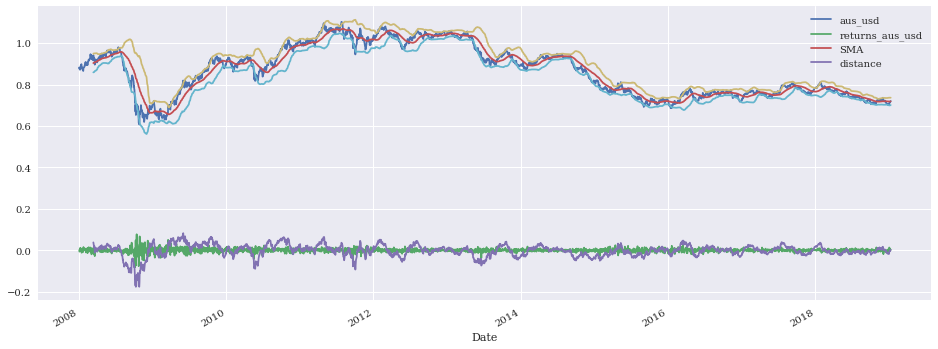

In [6]:
returns_df.plot(figsize=(16, 6), legend=True)
(returns_df.SMA + 2*std).plot();
(returns_df.SMA - 2*std).plot();



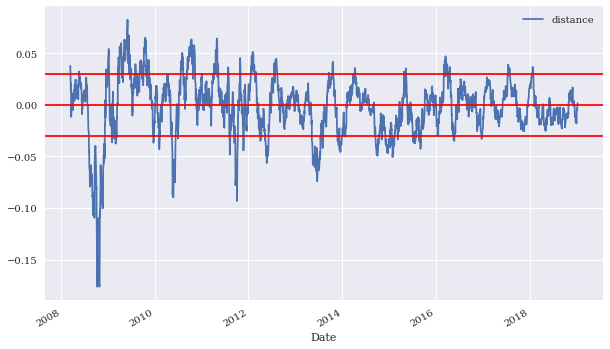

In [7]:
returns_df['distance'].dropna().plot(figsize=(10, 6), legend=True);
plt.axhline(threshold, color='r');
plt.axhline(-threshold, color='r');
plt.axhline(0, color='r');


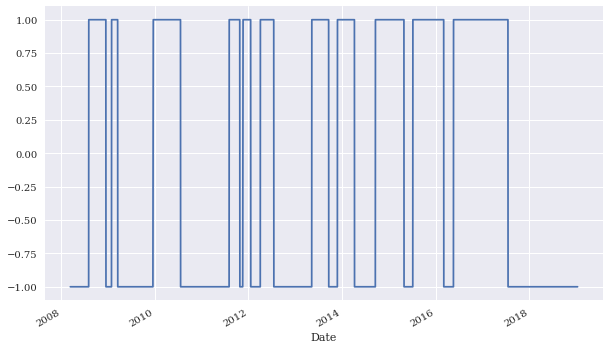

In [8]:
returns_df['position'] = np.where(returns_df['distance'] > threshold,-1, np.nan)
returns_df['position'] = np.where(returns_df['distance'] < -threshold,1, returns_df['position'])
returns_df['position'] = np.where(returns_df['position']*returns_df['position'].shift(1) < 0, 0, returns_df['position'])
returns_df['position'] = returns_df['position'].ffill().fillna(0)
returns_df['position'].iloc[SMA:].plot(ylim=[-1.1, 1.1],figsize=(10, 6));

In [9]:
returns_df['strategy'] = returns_df['position'].shift(1)*returns_df.returns_aus_usd

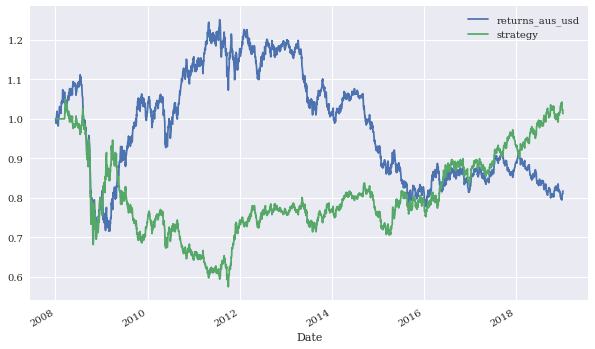

In [10]:
returns_df[['returns_aus_usd', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))

In [11]:
mr_jpy_usd = mrbt.MRVectorBacktester(df_currency, 'jpy_usd', '2008-01-02', '2019-01-11', 10000, 0.001)

In [12]:
#df_currency.head()

In [29]:
mr_jpy_usd.run_strategy(200, .001)

(6983.74, -3693.31)

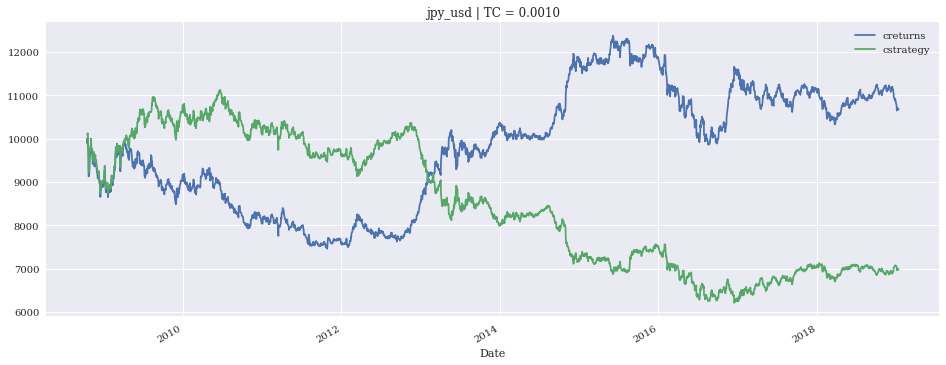

In [30]:
mr_jpy_usd.plot_results()